## Prédiction de la volatilité future d'un portefeuille d'actions technologiques

In [1]:
## import des librairies
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
## import des librairies pour la modélisation
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
## version de la librairie yfinance
print(yf.__version__)

0.2.66


In [4]:
# Liste des géants de la technologie
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA"]

# Téléchargement des données sur 5 ans
data = yf.download(tickers, start="2020-01-01", end="2025-01-01", threads=False)

data.head()

/var/folders/xx/01dz8x2j0c58d1hmyyx2c3b80000gn/T/ipykernel_11741/1415575438.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2025-01-01", threads=False)
[*********************100%***********************]  6 of 6 completed


Price           Close                                                          \
Ticker           AAPL       AMZN      GOOGL        META        MSFT      NVDA   
Date                                                                            
2020-01-02  72.468269  94.900497  67.965233  208.494690  152.791138  5.971409   
2020-01-03  71.763733  93.748497  67.609688  207.391479  150.888626  5.875830   
2020-01-06  72.335556  95.143997  69.411758  211.297440  151.278656  5.900473   
2020-01-07  71.995354  95.343002  69.277687  211.754608  149.899307  5.971908   
2020-01-08  73.153503  94.598503  69.770782  213.901367  152.286942  5.983109   

Price            High                                    ...       Open  \
Ticker           AAPL       AMZN      GOOGL        META  ...      GOOGL   
Date                                                     ...              
2020-01-02  72.528589  94.900497  67.965233  208.504623  ...  66.958679   
2020-01-03  72.523762  94.309998  68.217003  209.110876  ...  66.938323   
2020-01-06  72.374162  95.184502  69.437081  211.476329  ...  67.118569   
2020-01-07  72.600960  95.694504  69.694316  213.265300  ...  69.543357   
2020-01-08  73.455103  95.550003  70.108950  214.915122  ...  69.263281   

Price                                            Volume                      \
Ticker            META        MSFT      NVDA       AAPL      AMZN     GOOGL   
Date                                                                          
2020-01-02  205.483256  151.040826  5.942536  135480400  80580000  27278000   
2020-01-03  205.940433  150.603260  5.851687  146322800  75288000  23408000   
2020-01-06  205.433579  149.423705  5.782494  118387200  81236000  46768000   
2020-01-07  211.516088  151.554502  5.928848  108872000  80898000  34330000   
2020-01-08  211.694968  151.183478  5.967677  132079200  70160000  35314000   

Price                                      
Ticker          META      MSFT       NVDA  
Date                                       
2020-01-02  12077100  22622100  237536000  
2020-01-03  11188400  21116200  205384000  
2020-01-06  17058900  20813700  262636000  
2020-01-07  14912400  21634100  314856000  
2020-01-08  13475000  27746500  277108000  

[5 rows x 30 columns]

### Description des données

Le jeu de données est composé de plusieurs axes :
- Price (variable) : Close, High, Low, Open, Volume
- Ticker (entreprises technologiques) : AAPL, AMZN, GOOGL, META, MSFT, NVDA
- Date

On considère la variable Date comme l'index des lignes. Intéressons-nous davantage à la signification des variables associées au prix. 

In [5]:
## Liste des variables du dataframe
variables = data.columns.get_level_values(0).unique().tolist()
variables

['Close', 'High', 'Low', 'Open', 'Volume']

- Open : le prix d’ouverture d’une action, c’est-à-dire le premier prix auquel elle est échangée lorsque la bourse ouvre.
- High : le prix le plus haut atteint par l’action durant la journée.
- Low : le prix le plus bas atteint durant la journée.
- Close : le dernier prix de la journée, celui auquel la dernière transaction a eu lieu avant la clôture du marché.
- Volume : le nombre total d’actions échangées pendant la journée.

In [6]:
## Nombre d'observations du dataframe
f"On compte exactement {data.shape[0]} observations."

'On compte exactement 1258 observations.'

In [7]:
## Nombre de valeurs manquantes
data.isna().sum()

Price   Ticker
Close   AAPL      0
        AMZN      0
        GOOGL     0
        META      0
        MSFT      0
        NVDA      0
High    AAPL      0
        AMZN      0
        GOOGL     0
        META      0
        MSFT      0
        NVDA      0
Low     AAPL      0
        AMZN      0
        GOOGL     0
        META      0
        MSFT      0
        NVDA      0
Open    AAPL      0
        AMZN      0
        GOOGL     0
        META      0
        MSFT      0
        NVDA      0
Volume  AAPL      0
        AMZN      0
        GOOGL     0
        META      0
        MSFT      0
        NVDA      0
dtype: int64

In [8]:
for var in variables:
    print(var, "\n")
    display(data.describe()[var])

Close 



Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,151.659031,146.713811,118.299286,299.768842,287.533651,38.437575
std,41.929755,32.004698,32.297775,124.631882,81.572007,38.225554
min,54.264336,81.820000,52.345470,88.365250,129.171249,4.891361
25%,126.513710,121.000000,93.303978,208.507118,227.971054,13.570278
50%,150.247246,153.872498,118.880074,279.193863,275.338684,21.233308
75%,176.228844,170.000000,140.141434,344.786995,332.321281,45.616542
max,257.853760,232.929993,196.020935,630.696838,463.240967,148.837341


High 



Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,153.183638,148.537870,119.593237,303.820767,290.309498,39.147774
std,42.070380,32.124813,32.532144,125.735614,81.845481,38.935971
min,55.263186,83.480003,52.980093,89.905748,134.083611,5.228574
25%,127.633764,122.859997,94.619512,210.340823,230.553415,13.821395
50%,151.991609,155.915253,120.215367,283.487403,278.761210,21.739934
75%,177.782103,171.459248,141.127635,350.397375,335.737628,46.196023
max,258.928914,233.000000,200.765460,636.398941,464.023678,152.846179


Low 



Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,149.958964,144.831427,116.955190,295.599198,284.503738,37.663461
std,41.706645,31.898624,32.093320,123.458535,81.222794,37.481165
min,51.420157,81.301498,50.097971,87.550280,126.405063,4.499852
25%,124.509409,119.120497,91.672731,205.247213,224.781718,13.335314
50%,148.312209,151.760002,117.813668,274.602154,272.160040,20.820063
75%,174.661136,167.745750,138.838537,341.092270,329.795878,44.960825
max,256.470034,228.009995,194.346385,625.244010,460.169610,146.218059


Open 



Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,151.504428,146.739965,118.228748,299.611064,287.460539,38.441979
std,41.873457,32.066477,32.325633,124.786668,81.640095,38.286953
min,55.161608,82.075500,52.456703,89.528079,130.687870,4.983508
25%,125.957974,120.835373,93.189765,207.605176,228.154845,13.602299
50%,150.067184,153.920753,118.892491,277.464517,275.853895,21.167687
75%,176.034669,169.579128,140.031072,344.543488,332.213249,45.740965
max,257.027510,232.389999,196.609013,629.520541,462.686124,149.307200


Volume 



Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA
count,1.258000e+03,1.258000e+03,1.258000e+03,1.258000e+03,1.258000e+03,1.258000e+03
mean,9.057103e+07,6.848852e+07,3.308850e+07,2.314477e+07,2.863777e+07,4.467728e+08
std,5.324438e+07,3.402019e+07,1.461671e+07,1.573193e+07,1.273673e+07,1.876933e+08
min,2.323470e+07,1.500750e+07,9.312000e+06,4.726100e+06,7.164500e+06,9.788400e+07
25%,5.546825e+07,4.622560e+07,2.343938e+07,1.452880e+07,2.049260e+07,3.084230e+08
50%,7.628335e+07,6.006740e+07,2.943300e+07,1.938260e+07,2.548105e+07,4.205830e+08
75%,1.077425e+08,8.206700e+07,3.773515e+07,2.711575e+07,3.290642e+07,5.467242e+08
max,4.265100e+08,3.113460e+08,1.232000e+08,2.323166e+08,9.701270e+07,1.543911e+09


Notre objectif, ici, est de prédire la volatilité future du portefeuille sur 30 jours à partir de l’historique des prix.
On se focalise sur la variable *Close*.

## Préparation du portefeuille

### Volatilité

In [76]:
## Se focaliser sur le prix de clotûre
close_prices = data["Close"]

In [77]:
## Calculer les rendements journaliers
daily_ouput = close_prices.pct_change().dropna()

In [78]:
## Calculer un portefeuille pondéré
weights = [1/len(daily_ouput.columns)] * len(daily_ouput.columns)
portfolio_returns = (daily_ouput * weights).sum(axis=1)

In [79]:
## Calculer la volatilité glissante
rolling_volatility = portfolio_returns.rolling(window=30).std().shift(-30) * np.sqrt(252)

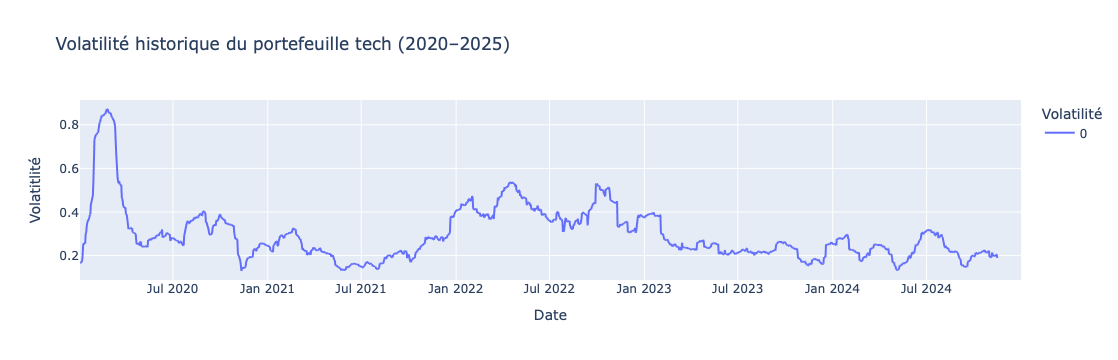

In [80]:
fig = px.line(rolling_volatility, 
              title = "Volatilité historique du portefeuille tech (2020–2025)",
             labels = {"value": "Volatitlité", "Date" : "Date", "variable" : "Volatilité"})
fig.show()

### Fourchette de variation journalière

In [11]:
## écart journalière
range_variation = data["High"] - data["Low"]

In [15]:
fig_range_variation = px.line(range_variation, 
              title = "Variation journalière des 6 tech (2020–2025)",
             labels = {"value": "Variation", "Date" : "Date", "variable" : "Variation"})
fig_range_variation.show()

## Modélisation

In [81]:
## Nommer la série
rolling_volatility.name = "vol_30_fwd"

In [82]:
## Construire un dataframe
df_portefeuille = pd.DataFrame(rolling_volatility)
df_portefeuille['returns'] = portfolio_returns

In [83]:
## Moyennes mobiles de rendement (ex : 7, 14, 30 jours)
for w in [7, 14, 30]:
    df_portefeuille[f'ma_ret_{w}'] = df_portefeuille['returns'].rolling(window=w).mean()

## Volatilité passée (ex : 7, 14, 30 jours) 
for w in [7, 14, 30]:
    df_portefeuille[f'vol_past_{w}'] = df_portefeuille['returns'].rolling(window=w).std() * np.sqrt(252)

## Lag features (retards de rendement)
max_lag = 5
for lag in range(1, max_lag+1):
    df_portefeuille[f'ret_lag_{lag}'] = df_portefeuille['returns'].shift(lag)

In [84]:
## Supprimer les valeurs manquantes
df_portefeuille = df_portefeuille.dropna()

In [85]:
## Séparer le dataframe en 2 parties 
features = [col for col in df_portefeuille.columns if col != "vol_30_fwd"]

X = df_portefeuille[features]
y = df_portefeuille["vol_30_fwd"]

n = len(X) # taille du dataframe

X_train, X_test = X.iloc[:int(n*0.8)], X.iloc[int(n*0.8):]
y_train, y_test = y.iloc[:int(n*0.8)], y.iloc[int(n*0.8):]

In [86]:
## Standardiser le dataframe avec les features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [87]:
def result_model(model, X_train, X_test, y_train, y_test):
    '''
    Retourner la performance d'un modèle calculée à partir des métriques MSE, MAE, R_2

    Attributs
    ---------
    model : 
        modèle de machine learning utilisé pour prédire
    X_train : pd.DataFrame
        données d'entraînement sur les features
    X_test : pd.DataFrame
        données de test sur les features
    y_train : pd.Series
        target d'entraînement
    y_test : pd. Series
        target de test

    Return
    ------
    results : dict
        liste des résultats
    y_predict : pd.Series
        prédiction sur les 30 prochains jours
    '''
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    results = {"MSE" : mean_squared_error(y_predict, y_test), 
               "MAE" : mean_absolute_error(y_predict, y_test), 
               "R_2" : r2_score(y_predict, y_test)}
    return results, y_predict

#### Linear Regression

In [88]:
linear_regression = LinearRegression()
lr_result, y_predict_reg = result_model(linear_regression, X_train_scaled, X_test_scaled, y_train, y_test)

In [91]:
lr_result

{'MSE': 0.01498605039163556,
 'MAE': 0.10223160716676093,
 'R_2': -2.24956480815037}

#### Random Forest

In [95]:
RandomForest = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_result, y_predict_rf = result_model(RandomForest, X_train_scaled, X_test_scaled, y_train, y_test)

In [96]:
rf_result

{'MSE': 0.021428147267283874,
 'MAE': 0.11587399815939965,
 'R_2': -1.120475177876243}

#### Gradient Boosting Regressor

In [97]:
GradientBoosting = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
gb_result, y_predict_gb = result_model(GradientBoosting, X_train_scaled, X_test_scaled, y_train, y_test)

In [98]:
gb_result

{'MSE': 0.020581943618602182,
 'MAE': 0.11393528528774895,
 'R_2': -1.0183699919774578}